In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

In the example below we will create simple LogisticRegression model and train it on synthetic data. We will use three different ways to do gradient descent 
1. Stochastic SGD 2. Batch-SGD 3. Diversified Mini-Batch SGD (DM-SGD)

In [13]:
class LogisticRegressionWithModifications:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.weights = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def create_similarity_kernel(self, X):
        distances = cdist(X, X, 'euclidean')
        sigma = np.std(distances)
        kernel = np.exp(-distances ** 2 / (2 * sigma ** 2))
        return kernel
    
    def diversified_selection(self, kernel, batch_size, n_samples):
        # Start with a randomly chosen index
        start_idx = np.random.randint(0, n_samples)
        selected = [start_idx]
        
        while len(selected) < batch_size:
            remaining = list(set(range(n_samples)) - set(selected))
            
            # Calculate total similarity for each remaining point to the selected points
            total_similarities = kernel[selected, :][:, remaining].sum(axis=0)
            
            # Choose the point with the minimum total similarity (maximizing diversity)
            min_similarity_idx = np.argmin(total_similarities)
            next_idx = remaining[min_similarity_idx]
            
            selected.append(next_idx)
        
        return np.array(selected)
    
    def fit_with_loss(self, X_train, y_train, batch_size=32, epochs=100, method='sgd'):
        n_samples, n_features = X_train.shape
        self.weights = np.zeros(n_features + 1)
        X_with_bias = np.hstack([np.ones((n_samples, 1)), X_train])
        losses = []
        
        for _ in range(epochs):
            if method == 'dm-sgd':
                kernel = self.create_similarity_kernel(X_train)
                print(kernel)
                selected = self.diversified_selection(kernel, batch_size, n_samples)
            elif method == 'sgd-single':
                selected = [np.random.randint(0, n_samples)]
            else:  # This includes mini-batch SGD
                selected = np.random.randint(0, n_samples, batch_size)
            
            X_batch = X_with_bias[selected]
            y_batch = y_train[selected]
            
            predictions = self.sigmoid(np.dot(X_batch, self.weights))
            gradient = np.dot(X_batch.T, (predictions - y_batch)) / len(selected)
            self.weights -= self.learning_rate * gradient
            
            loss = -np.mean(y_batch * np.log(predictions + 1e-9) + (1 - y_batch) * np.log(1 - predictions + 1e-9))
            losses.append(loss)
        
        return losses

# Generate synthetic data
X, y = make_blobs(n_samples=5000, centers=2, n_features=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train models with modified class
model_sgd_single = LogisticRegressionWithModifications()
losses_sgd_single = model_sgd_single.fit_with_loss(X_train, y_train, method='sgd-single')

model_mini_batch_sgd = LogisticRegressionWithModifications()
losses_mini_batch_sgd = model_mini_batch_sgd.fit_with_loss(X_train, y_train, batch_size=32)

model_dm_sgd = LogisticRegressionWithModifications()
losses_dm_sgd = model_dm_sgd.fit_with_loss(X_train, y_train, batch_size=32, method='dm-sgd')

[[1.         0.08207765 0.0416344  ... 0.99132414 0.97900149 0.95118444]
 [0.08207765 1.         0.96003385 ... 0.09774177 0.12736831 0.14261353]
 [0.0416344  0.96003385 1.         ... 0.05068344 0.06851667 0.07794857]
 ...
 [0.99132414 0.09774177 0.05068344 ... 1.         0.98733186 0.98067772]
 [0.97900149 0.12736831 0.06851667 ... 0.98733186 1.         0.98482381]
 [0.95118444 0.14261353 0.07794857 ... 0.98067772 0.98482381 1.        ]]
[[1.         0.08207765 0.0416344  ... 0.99132414 0.97900149 0.95118444]
 [0.08207765 1.         0.96003385 ... 0.09774177 0.12736831 0.14261353]
 [0.0416344  0.96003385 1.         ... 0.05068344 0.06851667 0.07794857]
 ...
 [0.99132414 0.09774177 0.05068344 ... 1.         0.98733186 0.98067772]
 [0.97900149 0.12736831 0.06851667 ... 0.98733186 1.         0.98482381]
 [0.95118444 0.14261353 0.07794857 ... 0.98067772 0.98482381 1.        ]]
[[1.         0.08207765 0.0416344  ... 0.99132414 0.97900149 0.95118444]
 [0.08207765 1.         0.96003385 ... 

/var/folders/qv/syr61wm55z900xcf7vv843vr0000gq/T/ipykernel_16216/2975335869.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, marker='x', edgecolors='k', label='Test')


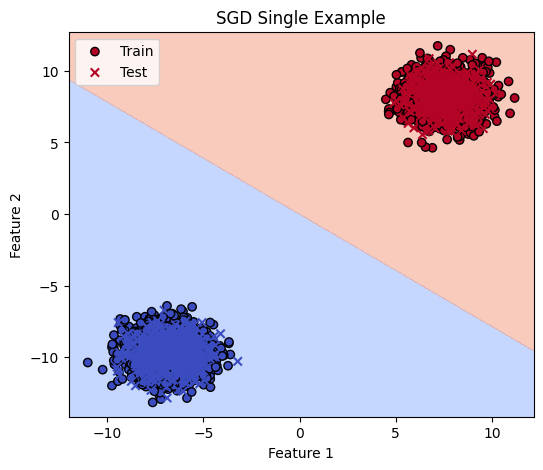

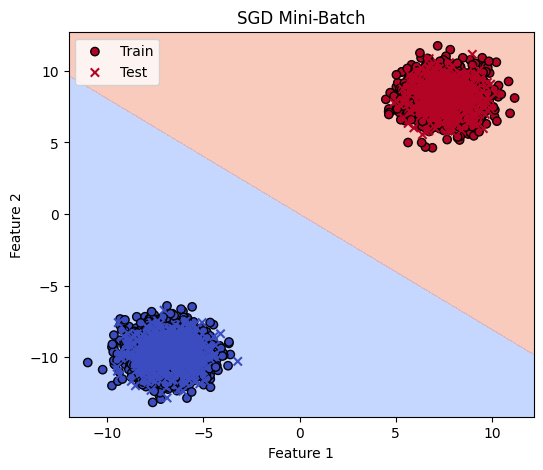

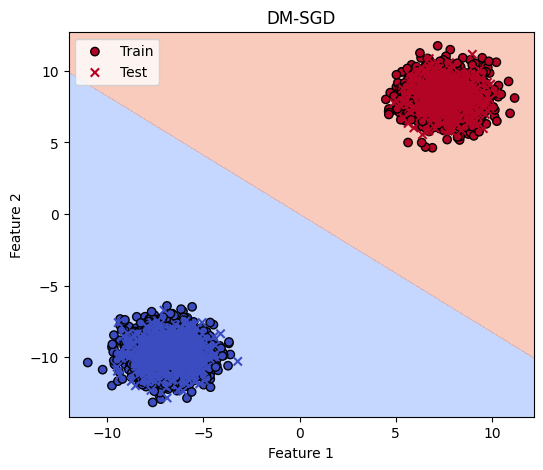

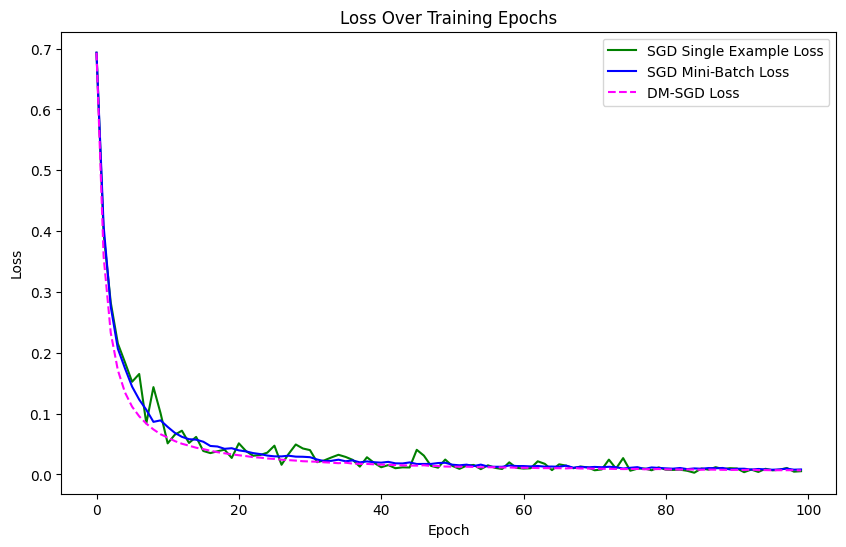

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have defined your model classes with a method sigmoid() and weights

# Define the function to plot decision boundaries
def plot_decision_boundary_with_data(model, X_train, y_train, X_test, y_test, title='Decision Boundary'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.sigmoid(np.dot(np.c_[xx.ravel(), yy.ravel()], model.weights[1:]) + model.weights[0])
    Z = Z > 0.5
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, marker='o', edgecolors='k', label='Train')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, marker='x', edgecolors='k', label='Test')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()

# Assuming the models have been trained and the datasets prepared
titles = ['SGD Single Example', 'SGD Mini-Batch', 'DM-SGD']
models = [model_sgd_single, model_mini_batch_sgd, model_dm_sgd]

# Loop over each model and create a separate figure for its decision boundary
for i, model in enumerate(models):
    plt.figure(figsize=(6, 5))
    plot_decision_boundary_with_data(model, X_train, y_train, X_test, y_test, titles[i])
    plt.show()

# Continue with the loss plotting as previously
plt.figure(figsize=(10, 6))
plt.plot(losses_sgd_single, label='SGD Single Example Loss', color='green')
plt.plot(losses_mini_batch_sgd, label='SGD Mini-Batch Loss', color='blue')
plt.plot(losses_dm_sgd, label='DM-SGD Loss', linestyle='--', color='magenta')
plt.title('Loss Over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In the example below we will create simple neural network model and train it on synthetic data first. We will use three different ways to do gradient descent 
1. Stochastic SGD 2. Batch-SGD 3. Diversified Mini-Batch SGD (DM-SGD)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist  # Added import for cdist


class SimpleNNWithCustomTraining:
    
    def create_similarity_kernel(self, X):
        distances = cdist(X, X, 'euclidean')
        sigma = np.std(distances)
        kernel = np.exp(-distances ** 2 / (2 * sigma ** 2))
        return kernel
    
    def diversified_selection(self, kernel, batch_size, n_samples):
        # Start with a randomly chosen index
        start_idx = np.random.randint(0, n_samples)
        selected = [start_idx]
        
        while len(selected) < batch_size:
            remaining = list(set(range(n_samples)) - set(selected))
            
            # Calculate total similarity for each remaining point to the selected points
            total_similarities = kernel[selected, :][:, remaining].sum(axis=0)
            
            # Choose the point with the minimum total similarity (maximizing diversity)
            min_similarity_idx = np.argmin(total_similarities)
            next_idx = remaining[min_similarity_idx]
            
            selected.append(next_idx)
        
        return np.array(selected)

    def __init__(self, input_dim, hidden_dim, learning_rate=0.01):
        self.model = Sequential([
            InputLayer(input_shape=(input_dim,)),
            Dense(hidden_dim, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        self.optimizer = SGD(learning_rate=learning_rate)
        self.model.compile(optimizer=self.optimizer, loss='binary_crossentropy')
        self.input_dim = input_dim

    def fit_with_loss(self, X_train, y_train, batch_size=32, epochs=100, method='sgd'):
        losses = []
        n_samples = X_train.shape[0]  # Define n_samples here
        for epoch in range(epochs):
            if method == 'dm-sgd':
                kernel = self.create_similarity_kernel(X_train)
                selected = self.diversified_selection(kernel, batch_size, n_samples)
                # Use diversified selected indices directly
                batch_indices = selected
            elif method == 'sgd-single':
                indices = np.random.randint(0, len(X_train), size=len(X_train))
            else:  # standard mini-batch SGD
                indices = np.arange(len(X_train))
                np.random.shuffle(indices)
            
            for i in range(0, len(X_train), batch_size):
                if method != 'dm-sgd':  # For dm-sgd, batch_indices is already defined
                    batch_indices = indices[i:i+batch_size]
                X_batch = X_train[batch_indices]
                y_batch = y_train[batch_indices]
                loss = self.model.train_on_batch(X_batch, y_batch)
                losses.append(loss)
        
        return losses

/Users/advaykoranne/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


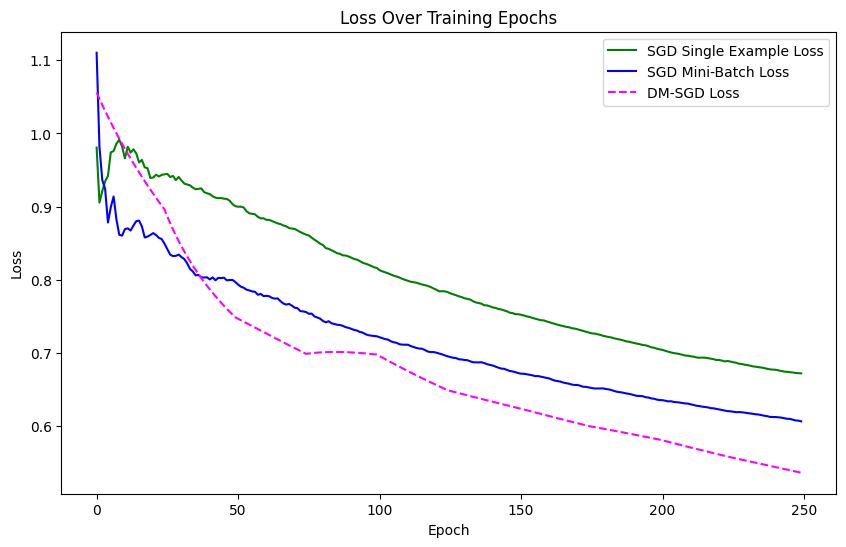

In [17]:

# Generating synthetic data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train models with modified class
model_sgd_single = SimpleNNWithCustomTraining(input_dim=20, hidden_dim=10)
losses_sgd_single = model_sgd_single.fit_with_loss(X_train, y_train, method='sgd-single', epochs=10)

model_mini_batch_sgd = SimpleNNWithCustomTraining(input_dim=20, hidden_dim=10)
losses_mini_batch_sgd = model_mini_batch_sgd.fit_with_loss(X_train, y_train, batch_size=32, epochs=10)

model_dm_sgd = SimpleNNWithCustomTraining(input_dim=20, hidden_dim=10)
losses_dm_sgd = model_dm_sgd.fit_with_loss(X_train, y_train, batch_size=32, method='dm-sgd', epochs=10)

# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(losses_sgd_single, label='SGD Single Example Loss', color='green')
plt.plot(losses_mini_batch_sgd, label='SGD Mini-Batch Loss', color='blue')
plt.plot(losses_dm_sgd, label='DM-SGD Loss', linestyle='--', color='magenta')
plt.title('Loss Over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

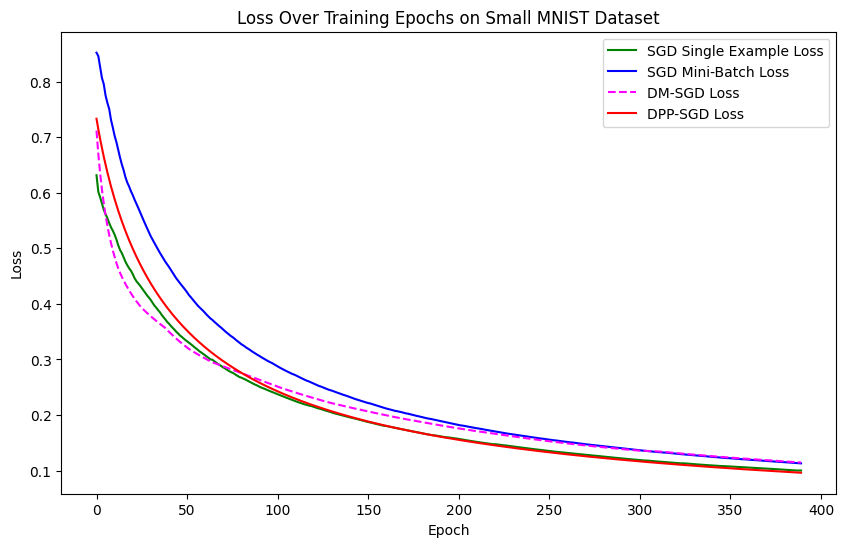

In [7]:
def load_small_mnist(num_samples=1000):
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)

    # For binary classification, let's use digits 0 and 1
    filter_indices = np.where((y == 0) | (y == 1))
    X, y = X[filter_indices][:num_samples], y[filter_indices][:num_samples]

    # Flatten and normalize
    X = X.reshape(X.shape[0], -1) / 255.0

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test# Load small MNIST data

X_train, X_test, y_train, y_test = load_small_mnist(num_samples=500)

# Initialize and train models with modified class for MNIST
input_dim = 784  # 28x28 pixels flattened
hidden_dim = 128  # You can adjust the size of the hidden layer
model_sgd_single = SimpleNNWithCustomTraining(input_dim=input_dim, hidden_dim=hidden_dim)
losses_sgd_single = model_sgd_single.fit_with_loss(X_train, y_train, method='sgd-single', epochs=30)

model_mini_batch_sgd = SimpleNNWithCustomTraining(input_dim=input_dim, hidden_dim=hidden_dim)
losses_mini_batch_sgd = model_mini_batch_sgd.fit_with_loss(X_train, y_train, batch_size=32, epochs=30)

model_dm_sgd = SimpleNNWithCustomTraining(input_dim=input_dim, hidden_dim=hidden_dim)
losses_dm_sgd = model_dm_sgd.fit_with_loss(X_train, y_train, batch_size=32, method='dm-sgd', epochs=30)

# Initialize and train the model with dpp-sgd method
model_dpp_sgd = SimpleNNWithCustomTraining(input_dim=input_dim, hidden_dim=hidden_dim)
losses_dpp_sgd = model_dpp_sgd.fit_with_loss(X_train, y_train, batch_size=32, method='dpp-sgd', epochs=30)

# Modify the plotting code to include the dpp-sgd losses
plt.figure(figsize=(10, 6))
plt.plot(losses_sgd_single, label='SGD Single Example Loss', color='green')
plt.plot(losses_mini_batch_sgd, label='SGD Mini-Batch Loss', color='blue')
plt.plot(losses_dm_sgd, label='DM-SGD Loss', linestyle='--', color='magenta')
plt.plot(losses_dpp_sgd, label='DPP-SGD Loss', linestyle='-', color='red')  # Add this line for dpp-sgd losses
plt.title('Loss Over Training Epochs on Small MNIST Dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In the example below we will create simple neural network model, but we will use Tensor flow's in-built DPP . We will use three different ways to do gradient descent 
1. Stochastic SGD 2. Batch-SGD 3. Diversified Mini-Batch SGD (DM-SGD)

In [21]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import time

class SimpleNNWithCustomTraining:
    
    def create_similarity_kernel(self, X):
        distances = cdist(X, X, 'euclidean')
        sigma = np.std(distances)
        kernel = np.exp(-distances ** 2 / (2 * sigma ** 2))
        return kernel

    def dpp_selection(self, X, batch_size):
        kernel_matrix = self.create_similarity_kernel(X)
        eigenvalues, eigenvectors = np.linalg.eigh(kernel_matrix)
        dpp = tfd.DeterminantalPointProcess(eigenvalues, eigenvectors)
        sampled_indices_multi_hot = dpp.sample(sample_shape=batch_size, seed=(1, 2))
        sampled_indices = [tf.where(samp).numpy().flatten() for samp in sampled_indices_multi_hot]
        if sampled_indices:
            return sampled_indices[0]
        else:
            return np.arange(len(X))

    def diversified_selection(self, kernel, batch_size, n_samples):
        start_idx = np.random.randint(0, n_samples)
        selected = [start_idx]
        while len(selected) < batch_size:
            remaining = list(set(range(n_samples)) - set(selected))
            total_similarities = kernel[selected, :][:, remaining].sum(axis=0)
            min_similarity_idx = np.argmin(total_similarities)
            next_idx = remaining[min_similarity_idx]
            selected.append(next_idx)
        return np.array(selected)

    def __init__(self, input_dim, hidden_dim, learning_rate=0.01):
        self.model = Sequential([
            InputLayer(input_shape=(input_dim,)),
            Dense(hidden_dim, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        self.optimizer = SGD(learning_rate=learning_rate)
        self.model.compile(optimizer=self.optimizer, loss='binary_crossentropy')

    def fit_with_loss(self, X_train, y_train, batch_size=32, epochs=50, method='sgd'):
        start_time = time.time()  # Start timing
        losses = []
        n_samples = X_train.shape[0]
        for epoch in range(epochs):
            if method == 'dpp-sgd':
                kernel = self.create_similarity_kernel(X_train)
                batch_indices = self.dpp_selection(kernel, batch_size)
            elif method == 'dm-sgd':
                kernel = self.create_similarity_kernel(X_train)
                selected = self.diversified_selection(kernel, batch_size, n_samples)
                batch_indices = selected
            elif method == 'sgd-single':
                indices = np.random.randint(0, len(X_train), size=len(X_train))
            else:
                indices = np.arange(len(X_train))
                np.random.shuffle(indices)
            
            for i in range(0, len(X_train), batch_size):
                if method not in ['dm-sgd', 'dpp-sgd']:
                    batch_indices = indices[i:i+batch_size]
                X_batch = X_train[batch_indices]
                y_batch = y_train[batch_indices]
                loss = self.model.train_on_batch(X_batch, y_batch)
                losses.append(loss)
        
        end_time = time.time()  # End timing
        training_time = end_time - start_time
        print(f"Training time for {method}: {training_time:.2f} seconds")
        return losses

# Example usage
X, y = make_classification(n_samples=500, n_features=20, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SimpleNNWithCustomTraining(input_dim=20, hidden_dim=10)
model.fit_with_loss(X_train, y_train, method='sgd-single', epochs=10)

Training time for sgd-single: 6.65 seconds


[array(0.83473337, dtype=float32),
 array(0.81574035, dtype=float32),
 array(0.82992506, dtype=float32),
 array(0.83869076, dtype=float32),
 array(0.82531834, dtype=float32),
 array(0.80595493, dtype=float32),
 array(0.8067609, dtype=float32),
 array(0.808965, dtype=float32),
 array(0.80636096, dtype=float32),
 array(0.8127645, dtype=float32),
 array(0.80608994, dtype=float32),
 array(0.79848367, dtype=float32),
 array(0.80108196, dtype=float32),
 array(0.8024271, dtype=float32),
 array(0.7981592, dtype=float32),
 array(0.79730797, dtype=float32),
 array(0.7903796, dtype=float32),
 array(0.7813924, dtype=float32),
 array(0.7817325, dtype=float32),
 array(0.77970046, dtype=float32),
 array(0.7748944, dtype=float32),
 array(0.7683675, dtype=float32),
 array(0.76848775, dtype=float32),
 array(0.76732546, dtype=float32),
 array(0.7663455, dtype=float32),
 array(0.7645744, dtype=float32),
 array(0.76322585, dtype=float32),
 array(0.7614447, dtype=float32),
 array(0.75897926, dtype=float32),

Training time for sgd-single: 6.76 seconds
Training time for sgd: 6.21 seconds
Training time for dm-sgd: 7.60 seconds
Training time for dpp-sgd: 1315.30 seconds


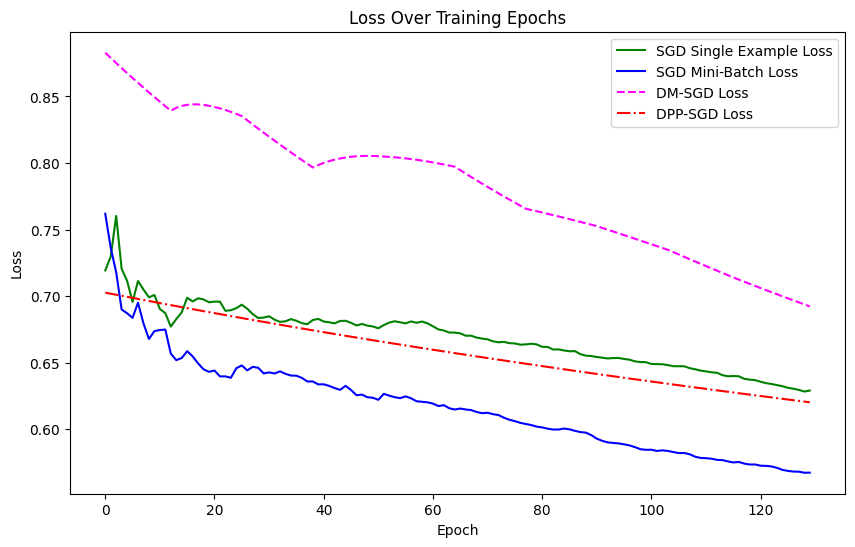

In [23]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Assuming the SimpleNNWithCustomTraining class definition is already available as modified

# Generating synthetic data
X, y = make_classification(n_samples=500, n_features=20, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train models with modified class
model_sgd_single = SimpleNNWithCustomTraining(input_dim=20, hidden_dim=10)
losses_sgd_single = model_sgd_single.fit_with_loss(X_train, y_train, method='sgd-single', epochs=10)

model_mini_batch_sgd = SimpleNNWithCustomTraining(input_dim=20, hidden_dim=10)
losses_mini_batch_sgd = model_mini_batch_sgd.fit_with_loss(X_train, y_train, batch_size=32, epochs=10)

model_dm_sgd = SimpleNNWithCustomTraining(input_dim=20, hidden_dim=10)
losses_dm_sgd = model_dm_sgd.fit_with_loss(X_train, y_train, batch_size=32, method='dm-sgd', epochs=10)

# New: Train model using DPP-SGD
model_dpp_sgd = SimpleNNWithCustomTraining(input_dim=20, hidden_dim=10)
losses_dpp_sgd = model_dpp_sgd.fit_with_loss(X_train, y_train, batch_size=32, method='dpp-sgd', epochs=10)

# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(losses_sgd_single, label='SGD Single Example Loss', color='green')
plt.plot(losses_mini_batch_sgd, label='SGD Mini-Batch Loss', color='blue')
plt.plot(losses_dm_sgd, label='DM-SGD Loss', linestyle='--', color='magenta')
plt.plot(losses_dpp_sgd, label='DPP-SGD Loss', linestyle='-.', color='red')  # New plot for DPP-SGD
plt.title('Loss Over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
